In [1]:
import collections
import pathlib
import random
import pickle
from typing import Dict, Tuple, Sequence

import cv2
from skimage.color import rgb2lab, lab2rgb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.autograd import Variable

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
srcfolder="./datasets/refined_img/"
inputfolder="./datasets/data/input/"
outputfolder="./datasets/data/output/"
oldpalette="./datasets/data/old_palette/"
newpalette="./datasets/data/new_palette/"
savemodel="./saved_models/"
trainfolder="./datasets/data/"


데이터 갯수 확인

In [4]:
import glob
print(f"# of files in input folder : {len(glob.glob(inputfolder + '/*'))}")
print(f"# of files in output folder : {len(glob.glob(outputfolder + '/*'))}")
print(f"# of files in old_palette folder : {len(glob.glob(oldpalette + '/*'))}")
print(f"# of files in new_palette folder : {len(glob.glob(newpalette + '/*'))}")
print(f"# of files in src folder : {len(glob.glob(srcfolder + '/*'))}")


# of files in input folder : 27
# of files in output folder : 27
# of files in old_palette folder : 27
# of files in new_palette folder : 27
# of files in src folder : 3


#### Feature Encoder (FE) and Recoloring Decoder (RD)

In [5]:
from functools import partial
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size

conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)

def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]

def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.InstanceNorm2d(out_channels))

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu'):
        super().__init__()
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()

    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x

    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            nn.BatchNorm2d(self.expanded_channels)) if self.should_apply_shortcut else None


    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion

    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

class ResNetBasicBlock(ResNetResidualBlock):
    """
    Basic ResNet block composed by two layers of 3x3conv/batchnorm/activation
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

class ResNetLayer(nn.Module):
    """
    A ResNet layer composed by `n` blocks stacked one after the other
    """
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion,
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

class FeatureEncoder(nn.Module):
    def __init__(self):
        super(FeatureEncoder, self).__init__()

        # convolutional
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.norm1_1 = nn.InstanceNorm2d(64)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # residual blocks
        self.res1 = ResNetLayer(64, 128, block=ResNetBasicBlock, n=1)
        self.res2 = ResNetLayer(128, 256, block=ResNetBasicBlock, n=1)
        self.res3 = ResNetLayer(256, 512, block=ResNetBasicBlock, n=1)

    def forward(self, x):
        x = F.relu(self.norm1_1(self.conv1_1(x)))
        c4 = self.pool1(x)
        c3 = self.res1(c4)
        c2 = self.res2(c3)
        c1 = self.res3(c2)
        return c1, c2, c3, c4

In [6]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.InstanceNorm2d(out_channels),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.InstanceNorm2d(out_channels),
    )

class RecoloringDecoder(nn.Module):
    # c => (bz, channel, h, w)
    # [Pt, c1]: (18 + 512) -> (256)
    # [c2, d1]: (256 + 256) -> (128)
    # [Pt, c3, d2]: (18 + 128 + 128) -> (64)
    # [Pt, c4, d3]: (18 + 64 + 64) -> 64
    # [Illu, d4]: (1 + 64) -> 3

    def __init__(self):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up_4 = double_conv(18 + 512, 256)
        self.dconv_up_3 = double_conv(256 + 256, 128)
        self.dconv_up_2 = double_conv(18 + 128 + 128, 64)
        self.dconv_up_1 = double_conv(18 + 64 + 64, 64)
        self.conv_last = nn.Conv2d(1 + 64, 3, 3, padding=1)


    def forward(self, c1, c2, c3, c4, target_palettes_1d, illu):
        bz, h, w = c1.shape[0], c1.shape[2], c1.shape[3]
        target_palettes = torch.ones(bz, 18, h, w).float().to(device)
        target_palettes = target_palettes.reshape(h, w, bz * 18) * target_palettes_1d
        target_palettes = target_palettes.permute(2, 0, 1).reshape(bz, 18, h, w)

        # concatenate target_palettes with c1
        x = torch.cat((c1.float(), target_palettes.float()), 1)
        x = self.dconv_up_4(x)
        x = self.upsample(x)

        # concatenate c2 with x
        x = torch.cat([c2, x], dim=1)
        x = self.dconv_up_3(x)
        x = self.upsample(x)

        # concatenate target_palettes and c3 with x
        bz, h, w = x.shape[0], x.shape[2], x.shape[3]
        target_palettes = torch.ones(bz, 18, h, w).float().to(device)
        target_palettes = target_palettes.reshape(h, w, bz * 18) * target_palettes_1d
        target_palettes = target_palettes.permute(2, 0, 1).reshape(bz, 18, h, w)
        x = torch.cat([target_palettes.float(), c3, x], dim=1)
        x = self.dconv_up_2(x)
        x = self.upsample(x)

        # concatenate target_palettes and c4 with x
        bz, h, w = x.shape[0], x.shape[2], x.shape[3]
        target_palettes = torch.ones(bz, 18, h, w).float().to(device)
        target_palettes = target_palettes.reshape(h, w, bz * 18) * target_palettes_1d
        target_palettes = target_palettes.permute(2, 0, 1).reshape(bz, 18, h, w)
        x = torch.cat([target_palettes.float(), c4, x], dim=1)
        x = self.dconv_up_1(x)
        x = self.upsample(x)
        illu = illu.view(illu.size(0), 1, illu.size(1), illu.size(2))
        x = torch.cat((x, illu), dim = 1)
        x = self.conv_last(x)
        return x

In [7]:
from torch.utils.data import Dataset, DataLoader
import pathlib

def get_illuminance(img):
    """
    Get the luminance of an image. Shape: (h, w)
    """
    img = img.permute(1, 2, 0)  # (h, w, channel)
    img = img.numpy()
    img = img.astype(float) / 255.0 #EIDT float!!
    img_LAB = rgb2lab(img)
    img_L = img_LAB[:,:,0]  # luminance  # (h, w)
    return torch.from_numpy(img_L)

class ColorTransferDataset(Dataset):
    def __init__(self, data_folder, transform):
        super().__init__()
        self.data_folder = data_folder
        self.transform = transform

    def __len__(self):
        output_folder = self.data_folder/"output"
        return len(list(output_folder.glob("*.jpg"))) ##EDIT.* > *.jpg

    def __getitem__(self, idx):
        input_img_folder = self.data_folder/"input"
        old_palette = self.data_folder/"old_palette"
        new_palette = self.data_folder/"new_palette"
        output_img_folder = self.data_folder/"output"
        files = list(output_img_folder.glob("*.jpg")) ##EDIT.* > *.jpg

        f = files[idx]
        ori_image = transform(cv2.imread(str(input_img_folder/f.name)))
        new_image = transform(cv2.imread(str(output_img_folder/f.name)))
        illu = get_illuminance(ori_image)

        new_palette = pickle.load(open(str(new_palette/f.stem) +'.pkl', 'rb'))
        new_palette = new_palette[:, :6, :].ravel() / 255.0 #EDIT

        old_palette = pickle.load(open(str(old_palette/f.stem) +'.pkl', 'rb'))
        old_palette = old_palette[:, :6, :].ravel() / 255.0 #EDIT

        ori_image = ori_image.double()
        new_image = new_image.double()
        illu = illu.double()
        new_palette = torch.from_numpy(new_palette).double()
        old_palette = torch.from_numpy(old_palette).double()

        return ori_image, new_image, illu, new_palette, old_palette

def viz_color_palette(hexcodes):
    """
    visualize color palette
    """
    hexcodes = list(hexcodes)
    while len(hexcodes) < 6: #헥스코드????
        hexcodes = hexcodes + hexcodes
    hexcodes = hexcodes[:6] #헥스코드????

    palette = []
    for hexcode in hexcodes:
        rgb = np.array(list(int(hexcode.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))
        palette.append(rgb)

    palette = np.array(palette)[np.newaxis, :, :]
    return palette

def viz_image_ori_new_out(ori, palette, new, out):
    """
    visualize original image, input palette, true new image, and output image from the model.
    """
    ori = ori.detach().cpu().numpy()
    new = new.detach().cpu().numpy()
    out = out.detach().cpu().numpy()
    palette = palette.detach().cpu().numpy()

    plt.imshow(np.transpose(ori, (1,2,0)), interpolation='nearest')
    plt.title("Original Image")
    plt.show()

    palette = palette.reshape((1, 6, 3))
    plt.imshow(palette, interpolation='nearest')
    plt.title("Palette")
    plt.show()

    # plt.imshow((np.transpose(out, (1,2,0)) * 255).astype(np.uint8))
    plt.imshow((np.transpose(out, (1,2,0))))
    plt.title("Output Image")
    plt.show()

    plt.imshow(np.transpose(new, (1,2,0)), interpolation='nearest')
    plt.title("True Image")
    plt.show()

#### TRAIN

In [8]:
# hyperparameters
bz = 16 #16
epoches = 1000 #EIDT
lr = 0.0002

# pre-processsing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
])


# dataset and dataloader
train_data = ColorTransferDataset(pathlib.Path(trainfolder), transform) #/home/jovyan/work/data/train
train_loader = DataLoader(train_data, batch_size=bz)

# create model, criterion and optimzer
FE = FeatureEncoder().float().to(device)
RD = RecoloringDecoder().float().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(list(FE.parameters()) + list(RD.parameters()), lr=lr, weight_decay=4e-3)

In [9]:
# train FE and RD
min_loss = float('inf')
for e in range(epoches):
    print("1st for")
    total_loss = 0.

    for i_batch, sampled_batched in enumerate(tqdm(train_loader)):
        ori_image, new_image, illu, new_palette, ori_palette = sampled_batched
        palette = new_palette.flatten()
        c1, c2, c3, c4 = FE.forward(ori_image.float().to(device))
        out = RD.forward(c1, c2, c3, c4, palette.float().to(device), illu.float().to(device))

        optimizer.zero_grad()

        loss = criterion(out, new_image.float().to(device))
        loss.backward()
        optimizer.step()
    total_loss += loss.item()
    print(e, total_loss)


    state = {
        'epoch': e,
        'FE': FE.state_dict(),
        'RD': RD.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(state, savemodel+str(e)+'_try FE_RD.pth')

    if total_loss < min_loss:
        min_loss = total_loss
        state = {
            'epoch': e,
            'FE': FE.state_dict(),
            'RD': RD.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, savemodel+'best_FE_RD.pth')

1st for


100%|██████████| 2/2 [00:30<00:00, 15.16s/it]


0 0.577485203742981
1st for


100%|██████████| 2/2 [00:26<00:00, 13.43s/it]


1 0.40348777174949646
1st for


100%|██████████| 2/2 [00:25<00:00, 12.87s/it]


2 0.36656826734542847
1st for


100%|██████████| 2/2 [00:25<00:00, 12.95s/it]


3 0.34958556294441223
1st for


100%|██████████| 2/2 [00:25<00:00, 12.92s/it]


4 0.3496612310409546
1st for


100%|██████████| 2/2 [00:25<00:00, 12.89s/it]


5 0.34394049644470215
1st for


100%|██████████| 2/2 [00:25<00:00, 12.83s/it]


6 0.3400286138057709
1st for


100%|██████████| 2/2 [00:26<00:00, 13.17s/it]


7 0.34001949429512024
1st for


100%|██████████| 2/2 [00:27<00:00, 13.69s/it]


8 0.33665353059768677
1st for


100%|██████████| 2/2 [00:31<00:00, 15.57s/it]


9 0.33415693044662476
1st for


100%|██████████| 2/2 [00:29<00:00, 14.89s/it]


10 0.33339786529541016
1st for


100%|██████████| 2/2 [00:29<00:00, 14.91s/it]


11 0.3315792977809906
1st for


100%|██████████| 2/2 [00:30<00:00, 15.15s/it]


12 0.329336017370224
1st for


100%|██████████| 2/2 [00:30<00:00, 15.46s/it]


13 0.3282482624053955
1st for


100%|██████████| 2/2 [00:30<00:00, 15.23s/it]


14 0.32715415954589844
1st for


100%|██████████| 2/2 [00:29<00:00, 14.78s/it]


15 0.3251074552536011
1st for


100%|██████████| 2/2 [00:29<00:00, 14.99s/it]


16 0.3235263228416443
1st for


100%|██████████| 2/2 [00:30<00:00, 15.24s/it]


17 0.32231655716896057
1st for


100%|██████████| 2/2 [00:30<00:00, 15.44s/it]


18 0.3207111358642578
1st for


100%|██████████| 2/2 [00:30<00:00, 15.30s/it]


19 0.3191259205341339
1st for


100%|██████████| 2/2 [00:30<00:00, 15.00s/it]


20 0.31785473227500916
1st for


100%|██████████| 2/2 [00:30<00:00, 15.47s/it]


21 0.3165086507797241
1st for


100%|██████████| 2/2 [00:31<00:00, 15.52s/it]


22 0.3149898052215576
1st for


100%|██████████| 2/2 [00:30<00:00, 15.43s/it]


23 0.3135034143924713
1st for


100%|██████████| 2/2 [00:30<00:00, 15.27s/it]


24 0.3119833767414093
1st for


100%|██████████| 2/2 [00:29<00:00, 14.76s/it]


25 0.31044405698776245
1st for


100%|██████████| 2/2 [00:29<00:00, 14.86s/it]


26 0.30898571014404297
1st for


100%|██████████| 2/2 [00:30<00:00, 15.34s/it]


27 0.3074709177017212
1st for


  0%|          | 0/2 [00:16<?, ?it/s]


KeyboardInterrupt: 

In [11]:
# load model from saved model file
state = torch.load(savemodel+'10_try FE_RD.pth',map_location=torch.device('cpu')) #/home/jovyan/work/saved_models/FE_RD.pth
FE = FeatureEncoder().float().to(device)
RD = RecoloringDecoder().float().to(device)
FE.load_state_dict(state['FE'])
RD.load_state_dict(state['RD'])
optimizer.load_state_dict(state['optimizer'])

for i_batch, sampled_batched in enumerate(train_loader):
    ori_image, new_image, illu, new_palette, ori_palette = sampled_batched
    flat_palette = new_palette.flatten()
    c1, c2, c3, c4 = FE.forward(ori_image.float().to(device))
    out = RD.forward(c1, c2, c3, c4, flat_palette.float().to(device), illu.float().to(device))
    break

10


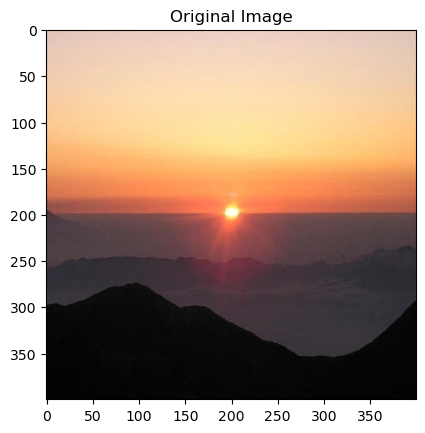

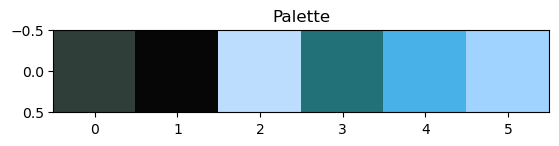

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


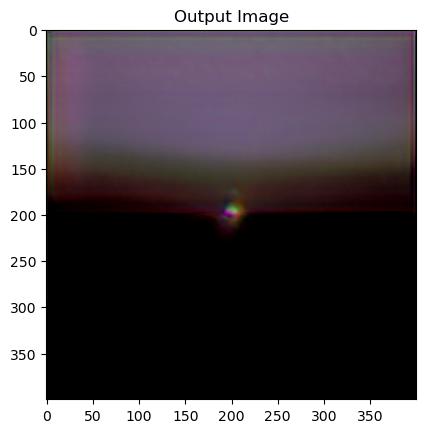

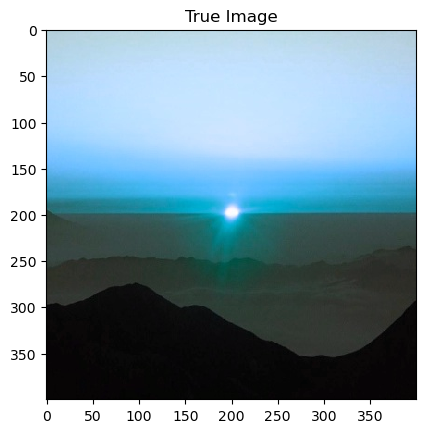

In [12]:
idx = 2
print(state['epoch'])
viz_image_ori_new_out(ori_image[idx], new_palette[idx], new_image[idx], out[idx])